In [6]:
import pandas as pd
from tqdm import tqdm
from scipy.spatial import KDTree
import seaborn as sns

In [152]:
def read(file_name):
    try:
        fasta = open(file_name, 'r')
        fasta_pairs = {}
        header = ''
        # check every line for a new header
        # if so, set as key and set non header lines as value
        for line in fasta:
            if line[0] == '>':
                header = line.strip('\n')
                fasta_pairs[header] = ''
            else:
                fasta_pairs[header] += line.strip('\n')
        # return dict of fasta entries
        return fasta_pairs
    except IOError:
        print("File \"{}\" could not be opened.".format(file_name))

## Do it via the known output:

In [153]:
cf = pd.read_pickle("../01_preparation/clear-fusion/clear-fusion_tama_augustus.pkl")
cf["gene_id"]=cf["accession"]+"_"+cf["gene"]
cf["isoform_id"]=cf["accession"]+"_"+cf["isoform"]

In [154]:
lengths=pd.DataFrame()
for acc in tqdm(cf["accession"].unique().tolist()):
    # -------------1-------------
    # prepare sqanti output
    sqanti = pd.read_csv("/ebio/abt6_projects7/dliso/dlis/leon_pipeline/output/v2/collapse_tama/{}_augustus_sqanti/{}-tama-vs-augustus_classification.txt".format(acc,acc), sep="\t")
    sqanti["gene"] = sqanti["isoform"].str.split(".").str[0]
    sqanti["isoform_id"] = acc+"_"+sqanti["isoform"]
    sub = sqanti[["ORF_length","CDS_length","isoform_id"]]
    lengths=pd.concat([lengths,sub])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:42<00:00,  2.35s/it]


In [155]:
cf=pd.merge(cf, lengths, on=["isoform_id"], how="left")

In [156]:
cf

,gene,isoform,accession,associated_gene,associated_transcript,exons,length,isoform_read_support,gene_read_support,structural_category,...,cat_read_support,gene_association_read_support,type,isoforms_per_gene,ORFs_per_gene,isoforms_per_ORFs,gene_id,isoform_id,ORF_length,CDS_length
0,G1128,G1128.10,at6923,g1555,novel,1,3275,1,59,genic,...,59,12,nlr,11,2,8.0,at6923_G1128,at6923_G1128.10,393.0,1182.0
1,G1128,G1128.11,at6923,g1555,novel,1,2744,1,59,genic,...,59,12,nlr,11,2,3.0,at6923_G1128,at6923_G1128.11,395.0,1188.0
2,G1128,G1128.12,at6923,g1555,novel,1,2795,1,59,genic,...,59,12,nlr,11,2,3.0,at6923_G1128,at6923_G1128.12,395.0,1188.0
3,G1128,G1128.13,at6923,g1555,novel,1,1821,1,59,genic,...,59,12,nlr,11,2,3.0,at6923_G1128,at6923_G1128.13,395.0,1188.0
4,G1128,G1128.2,at6923,g1555,novel,2,3331,1,59,novel_not_in_catalog,...,59,12,nlr,11,2,8.0,at6923_G1128,at6923_G1128.2,393.0,1182.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408192,G16302,G16302.24,col0,ATCG01310_ATCG01300,novel,2,818,1,136,fusion,...,15,15,other,49,8,2.0,col0_G16302,col0_G16302.24,253.0,759.0
3408193,G16302,G16302.26,col0,ATCG01310_ATCG01300,novel,2,831,2,136,fusion,...,15,15,other,49,8,4.0,col0_G16302,col0_G16302.26,257.0,771.0
3408194,G16302,G16302.5,col0,ATCG01310_ATCG01300,novel,2,1204,1,136,fusion,...,15,15,other,49,8,4.0,col0_G16302,col0_G16302.5,257.0,771.0
3408195,G16302,G16302.7,col0,ATCG01310_ATCG01300,novel,2,1141,6,136,fusion,...,15,15,other,49,8,4.0,col0_G16302,col0_G16302.7,257.0,771.0


In [50]:
def get_template():
    template={
        #general: calculate mean
        "exons":0,
        "length":0,
        #"gene_read_support":0,
        #structural_category
        "genic":0,
        "novel_not_in_catalog":0,
        "full-splice_match":0,
        "incomplete-splice_match":0,
        "novel_in_catalog":0,
        #add extra
        "fusion":0,
        #subcategory
        'mono-exon':0,
        'intron_retention':0,
        'alternative_3end5end':0,
        '3prime_fragment':0,
        'at_least_one_novel_splicesite':0,
        'mono-exon_by_intron_retention':0,
        '5prime_fragment':0,
        'alternative_3end':0,
        'internal_fragment':0,
        'alternative_5end':0,
        'multi-exon':0,
        'reference_match':0,
        'combination_of_known_splicesites':0,
        'combination_of_known_junctions':0,
        #calculate total from df
        "n_ORFs":0,
        "n_isoforms":0,
        "n_noncoding":0,
        # calculate mean, get from squanti direct
        "ORF_length":0,
        "CDS_length":0
    }
    return template

In [157]:
def gene_from_iso(g):
    df=g[1]
    gene=get_template()
    #general:
    gene["exons"]=df["exons"].apply("mean")
    gene["length"]=df["length"].apply("mean")
    #structural_category:
    cat=df["structural_category"].value_counts().rename_axis('unique_values').reset_index(name='counts')
    for c in cat["unique_values"].unique().tolist():
        gene[c]+=cat.loc[cat["unique_values"]==c]["counts"].astype(int).tolist()[0]

    #subcategory:
    subcat=df["subcategory"].value_counts().rename_axis('unique_values').reset_index(name='counts')
    for sc in subcat["unique_values"].unique().tolist():
        gene[sc]+=subcat.loc[subcat["unique_values"]==sc]["counts"].astype(int).tolist()[0]

    #calculate from df:
    gene["n_ORFs"]=len(df["Sqanti_ORF_seq"].dropna().unique())
    gene["n_isoforms"]=len(df)
    gene["n_noncoding"]=df["Sqanti_ORF_seq"].isna().sum()
    
    # more:
    gene["ORF_length"]=df["ORF_length"].apply("mean")
    gene["CDS_length"]=df["CDS_length"].apply("mean")
    
    out=pd.DataFrame.from_dict([gene])
    out["gene"]=g[0]
    
    if "nlr" in df["type"].tolist():
        out["type"]="nlr"
    else:
        out["type"]="other"
        
    return out

In [52]:
all_genes=pd.DataFrame()
for g in tqdm(cf.groupby("gene_id")):
    gene=gene_from_iso(g)
    all_genes=pd.concat([all_genes, gene], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282538/282538 [1:47:11<00:00, 43.93it/s]


In [53]:
all_genes=all_genes.reset_index(drop=True)

In [54]:
all_genes.to_pickle("all_genes.pkl")

In [75]:
all_genes["accession"]=all_genes["gene"].str.split("_").str[0]
all_genes.fillna(0, inplace=True)

In [7]:
all_genes = pd.read_pickle("all_genes.pkl")
all_genes["accession"]=all_genes["gene"].str.split("_").str[0]
all_genes.fillna(0, inplace=True)

In [8]:
all_genes

,exons,length,genic,novel_not_in_catalog,full-splice_match,incomplete-splice_match,novel_in_catalog,fusion,mono-exon,intron_retention,...,combination_of_known_splicesites,combination_of_known_junctions,n_ORFs,n_isoforms,n_noncoding,ORF_length,CDS_length,gene,type,accession
0,6.000000,1625.500000,0,0,2,0,0,0,0,0,...,0,0,1,2,0,429.000000,1290.000000,at6923_G1,other,at6923
1,2.727273,1518.863636,2,1,16,3,0,0,2,1,...,0,0,5,22,0,391.863636,1178.590909,at6923_G10,other,at6923
2,2.000000,1686.000000,3,0,0,0,0,0,0,0,...,0,0,1,3,0,443.000000,1332.000000,at6923_G100,other,at6923
3,9.833333,1258.916667,0,3,9,0,0,0,0,2,...,0,0,4,12,0,304.416667,916.250000,at6923_G1000,other,at6923
4,2.375000,1753.500000,6,0,2,0,0,0,2,0,...,0,0,2,8,0,317.250000,954.750000,at6923_G10000,other,at6923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282533,7.625000,2574.475000,1,5,19,15,0,0,1,0,...,0,0,8,40,1,654.435897,1966.307692,col0_G9995,other,col0
282534,7.029412,2215.764706,0,3,31,0,0,0,0,0,...,0,0,4,34,0,590.970588,1775.911765,col0_G9996,other,col0
282535,4.833333,2230.333333,0,0,5,0,1,0,0,1,...,0,0,3,6,0,560.333333,1684.000000,col0_G9997,other,col0
282536,9.833333,1708.833333,0,0,5,0,1,0,0,1,...,0,0,2,6,0,427.166667,1284.500000,col0_G9998,other,col0


### KDtree search

In [183]:
nn_all=pd.DataFrame()
nn_nlr={}
gene_dict={}
for acc in all_genes["accession"].unique().tolist():
    # get acc subsets by type
    acc_df=all_genes.loc[all_genes["accession"]==acc]
    # hande NLR
    nlr_values=acc_df.loc[acc_df["type"]=="nlr"].drop(["accession","gene","type"], axis=1)
    nlr_values.reset_index(drop=True, inplace=True)
    nlr_labels=acc_df.loc[acc_df["type"]=="nlr"][["accession","gene","type"]]
    nlr_labels.reset_index(drop=True, inplace=True)
    
    all_values=acc_df.drop(["accession","gene","type"], axis=1)
    all_values.reset_index(drop=True, inplace=True)
    all_labels=acc_df[["accession","gene","type"]]
    all_labels.reset_index(drop=True, inplace=True)
    
    # build tree
    kdB = KDTree(all_values)
    nn= kdB.query(nlr_values, k=5)[-1]
    
    # get corresponding genes from all_labels
    ids=[]
    nn_nlr[acc]=[]
    for i in nn:
        c=0
        genes=[]
        for g in i:
            if all_labels.iloc[g]["type"] == "nlr":
                c+=1
            else:
                genes.append(all_labels.iloc[g]["gene"].split("_")[1])

        nn_nlr[acc].append(c)    
        ids.append(genes)
        
    
    # create full df per acc
    genes_df=pd.DataFrame(ids)
    genes_df=pd.concat([nlr_labels, genes_df], axis=1)
    nn_all=pd.concat([nn_all, genes_df])
    
    # create dict entry per acc
    gene_dict[acc]= set([g for sublist in ids for g in sublist])

In [184]:
nn_all.reset_index(inplace=True, drop=True)
nn_all["gene"]=nn_all[["gene"]].apply(lambda x: x.str.split("_").str[1])

In [185]:
nn_all

,accession,gene,type,0,1,2,3
0,at6923,G10741,nlr,G3115,G14997,G2619,G14514
1,at6923,G10742,nlr,G3795,G14221,G6523,G5357
2,at6923,G10891,nlr,G6971,G2545,G12502,G6128
3,at6923,G10892,nlr,G12628,G10528,G8630,G13087
4,at6923,G11053,nlr,G11535,G3921,G4093,G5074
...,...,...,...,...,...,...,...
2249,col0,G8732,nlr,G986,G16039,G10906,G8201
2250,col0,G8733,nlr,G7079,G6793,G8916,G13554
2251,col0,G8734,nlr,G1776,G7032,G7951,G13328
2252,col0,G8810,nlr,G9386,G10244,G4795,G3895


In [186]:
nn_nlr_dict={}
for acc in nn_nlr.keys():
    nn_nlr_dict[acc]=[]
    nn_nlr_dict[acc].append(nn_nlr[acc].count(0))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(1))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(2))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(3))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(4))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(5))

In [187]:
nn_nlr_df=pd.DataFrame(nn_nlr_dict)
nn_nlr_df=nn_nlr_df.T.reset_index()
nn_nlr_df.columns=["index","0","1","2","3","4","5"]

In [188]:
nn_nlr_plot=nn_nlr_df.melt(id_vars=["index"], value_vars=["0","1","2","3","4","5"])

Text(0, 0.5, 'Counts')

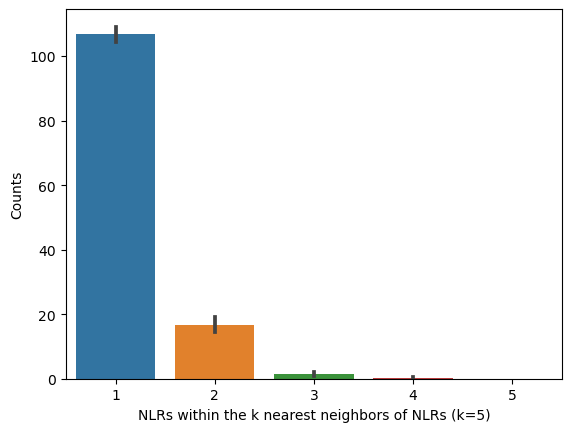

In [189]:
p1=sns.barplot(nn_nlr_plot, x="variable", y="value")
p1.set_xlabel("NLRs within the k nearest neighbors of NLRs (k=5)")
p1.set_ylabel("Counts")

In [190]:
fig = p1.get_figure()
fig.savefig("knn_5_no_co_nlrs.png", bbox_inches='tight', dpi=200)

In [191]:
## get all isoforms per gene
iso_dict={}
for acc in cf["accession"].unique().tolist():
    isos=[]
    acc_df=cf.loc[cf["accession"]==acc]
    for gene in acc_df.groupby("gene"):
        if gene[0] in gene_dict[acc]:
            isos.extend(gene[1]["isoform"].tolist())
    iso_dict[acc]=isos

In [193]:
for acc in iso_dict.keys():
    fasta = read(f"../../output/v2/collapse_tama/{acc}_transdecoder/{acc}_transcripts.fasta.transdecoder.pep")
    
    f_out=[]
    for g in fasta.keys():
        name = g.replace(">","").split(".")[0] +"."+ g.replace(">","").split(".")[1]
        if name in iso_dict[f"{acc}"]:
            f_out.append(g)
            
    ofile = open(f"input/n5_genes_all/{acc}_nlr_like.prot.fasta", "w")

    for g in f_out:
        ofile.write(g + "\n" + fasta[g].replace("*","") + "\n")

    #do not forget to close it
    ofile.close()

### create a second run without CDS and ORF

In [256]:
t=pd.read_pickle("all_genes.pkl")
all_genes["accession"]=all_genes["gene"].str.split("_").str[0]
all_genes.fillna(0, inplace=True)

In [257]:
t

,exons,length,genic,novel_not_in_catalog,full-splice_match,incomplete-splice_match,novel_in_catalog,fusion,mono-exon,intron_retention,...,reference_match,combination_of_known_splicesites,combination_of_known_junctions,n_ORFs,n_isoforms,n_noncoding,ORF_length,CDS_length,gene,type
0,6.000000,1625.500000,0,0,2,0,0,0,0,0,...,0,0,0,1,2,0,429.000000,1290.000000,at6923_G1,other
1,2.727273,1518.863636,2,1,16,3,0,0,2,1,...,0,0,0,5,22,0,391.863636,1178.590909,at6923_G10,other
2,2.000000,1686.000000,3,0,0,0,0,0,0,0,...,0,0,0,1,3,0,443.000000,1332.000000,at6923_G100,other
3,9.833333,1258.916667,0,3,9,0,0,0,0,2,...,0,0,0,4,12,0,304.416667,916.250000,at6923_G1000,other
4,2.375000,1753.500000,6,0,2,0,0,0,2,0,...,0,0,0,2,8,0,317.250000,954.750000,at6923_G10000,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282533,7.625000,2574.475000,1,5,19,15,0,0,1,0,...,6,0,0,8,40,1,654.435897,1966.307692,col0_G9995,other
282534,7.029412,2215.764706,0,3,31,0,0,0,0,0,...,9,0,0,4,34,0,590.970588,1775.911765,col0_G9996,other
282535,4.833333,2230.333333,0,0,5,0,1,0,0,1,...,3,0,0,3,6,0,560.333333,1684.000000,col0_G9997,other
282536,9.833333,1708.833333,0,0,5,0,1,0,0,1,...,3,0,0,2,6,0,427.166667,1284.500000,col0_G9998,other


In [258]:
all_genes = all_genes[['exons', 'length', 'genic', 'novel_not_in_catalog', 'full-splice_match',
       'incomplete-splice_match', 'novel_in_catalog', 'fusion', 'mono-exon',
       'intron_retention', 'alternative_3end5end', '3prime_fragment',
       'at_least_one_novel_splicesite', 'mono-exon_by_intron_retention',
       '5prime_fragment', 'alternative_3end', 'internal_fragment',
       'alternative_5end', 'multi-exon', 'reference_match',
       'combination_of_known_splicesites', 'combination_of_known_junctions',
       'n_ORFs', 'n_isoforms', 'n_noncoding',
       'gene', 'type', 'accession']]

In [259]:
nn_all=pd.DataFrame()
nn_nlr={}
gene_dict={}
for acc in all_genes["accession"].unique().tolist():
    # get acc subsets by type
    acc_df=all_genes.loc[all_genes["accession"]==acc]
    # hande NLR
    nlr_values=acc_df.loc[acc_df["type"]=="nlr"].drop(["accession","gene","type"], axis=1)
    nlr_values.reset_index(drop=True, inplace=True)
    nlr_labels=acc_df.loc[acc_df["type"]=="nlr"][["accession","gene","type"]]
    nlr_labels.reset_index(drop=True, inplace=True)
    
    all_values=acc_df.drop(["accession","gene","type"], axis=1)
    all_values.reset_index(drop=True, inplace=True)
    all_labels=acc_df[["accession","gene","type"]]
    all_labels.reset_index(drop=True, inplace=True)
    
    # build tree
    kdB = KDTree(all_values)
    nn= kdB.query(nlr_values, k=5)[-1]
    
    # get corresponding genes from other_labels
    ids=[]
    nn_nlr[acc]=[]
    for i in nn:
        c=0
        genes=[]
        for g in i:
            if all_labels.iloc[g]["type"] == "nlr":
                c+=1
            else:
                genes.append(all_labels.iloc[g]["gene"].split("_")[1])

        nn_nlr[acc].append(c)    
        ids.append(genes)
    
    # create full df per acc
    genes_df=pd.DataFrame(ids)
    genes_df=pd.concat([nlr_labels, genes_df], axis=1)
    nn_all=pd.concat([nn_all, genes_df])
    
    # create dict entry per acc
    gene_dict[acc]= set([g for sublist in ids for g in sublist])

In [260]:
nn_all.reset_index(inplace=True, drop=True)
nn_all["gene"]=nn_all[["gene"]].apply(lambda x: x.str.split("_").str[1])

In [261]:
nn_nlr_dict={}
for acc in nn_nlr.keys():
    nn_nlr_dict[acc]=[]
    nn_nlr_dict[acc].append(nn_nlr[acc].count(0))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(1))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(2))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(3))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(4))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(5))

In [262]:
nn_nlr_df=pd.DataFrame(nn_nlr_dict)
nn_nlr_df=nn_nlr_df.T.reset_index()
nn_nlr_df.columns=["index","0","1","2","3","4","5"]

In [263]:
nn_nlr_plot=nn_nlr_df.melt(id_vars=["index"], value_vars=["0","1","2","3","4","5"])

Text(0, 0.5, 'Counts')

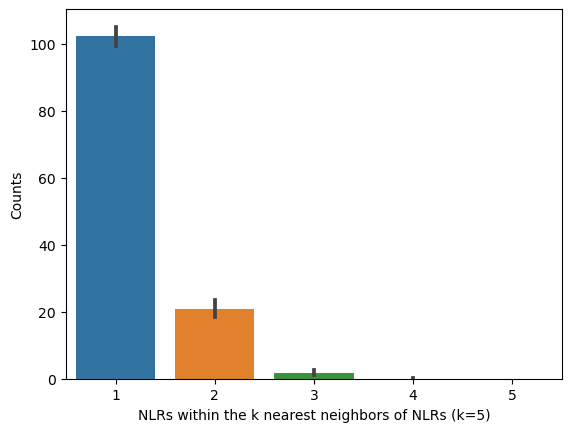

In [264]:
p1=sns.barplot(nn_nlr_plot, x="variable", y="value")
p1.set_xlabel("NLRs within the k nearest neighbors of NLRs (k=5)")
p1.set_ylabel("Counts")

In [265]:
fig = p1.get_figure()
fig.savefig("knn_5_no_co_nlrs.png", bbox_inches='tight', dpi=200)

In [205]:
## get all isoforms per gene
iso_dict={}
for acc in cf["accession"].unique().tolist():
    isos=[]
    acc_df=cf.loc[cf["accession"]==acc]
    for gene in acc_df.groupby("gene"):
        if gene[0] in gene_dict[acc]:
            isos.extend(gene[1]["isoform"].tolist())
    iso_dict[acc]=isos

In [206]:
for acc in iso_dict.keys():
    fasta = read(f"../../output/v2/collapse_tama/{acc}_transdecoder/{acc}_transcripts.fasta.transdecoder.pep")
    
    f_out=[]
    for g in fasta.keys():
        name = g.replace(">","").split(".")[0] +"."+ g.replace(">","").split(".")[1]
        if name in iso_dict[f"{acc}"]:
            f_out.append(g)
            
    ofile = open(f"input/n5_genes_all/{acc}_no_co_nlr_like.prot.fasta", "w")

    for g in f_out:
        ofile.write(g + "\n" + fasta[g].replace("*","") + "\n")

    #do not forget to close it
    ofile.close()

### create a third run with only sqanti categories


In [142]:
all_genes = all_genes[['genic', 'novel_not_in_catalog', 'full-splice_match',
       'incomplete-splice_match', 'novel_in_catalog', 'fusion', 'mono-exon',
       'intron_retention', 'alternative_3end5end', '3prime_fragment',
       'at_least_one_novel_splicesite', 'mono-exon_by_intron_retention',
       '5prime_fragment', 'alternative_3end', 'internal_fragment',
       'alternative_5end', 'multi-exon', 'reference_match',
       'combination_of_known_splicesites', 'combination_of_known_junctions',
       'n_ORFs', 'n_isoforms', 'n_noncoding',
       'gene', 'type', 'accession']]

In [143]:
nn_all=pd.DataFrame()
nn_nlr={}
gene_dict={}
for acc in all_genes["accession"].unique().tolist():
    # get acc subsets by type
    acc_df=all_genes.loc[all_genes["accession"]==acc]
    # hande NLR
    nlr_values=acc_df.loc[acc_df["type"]=="nlr"].drop(["accession","gene","type"], axis=1)
    nlr_values.reset_index(drop=True, inplace=True)
    nlr_labels=acc_df.loc[acc_df["type"]=="nlr"][["accession","gene","type"]]
    nlr_labels.reset_index(drop=True, inplace=True)
    
    all_values=acc_df.drop(["accession","gene","type"], axis=1)
    all_values.reset_index(drop=True, inplace=True)
    all_labels=acc_df[["accession","gene","type"]]
    all_labels.reset_index(drop=True, inplace=True)
    
    # build tree
    kdB = KDTree(all_values)
    nn= kdB.query(nlr_values, k=5)[-1]
    
    # get corresponding genes from other_labels
    ids=[]
    nn_nlr[acc]=[]
    for i in nn:
        c=0
        genes=[]
        for g in i:
            if all_labels.iloc[g]["type"] == "nlr":
                c+=1
            else:
                genes.append(all_labels.iloc[g]["gene"].split("_")[1])

        nn_nlr[acc].append(c)    
        ids.append(genes)
    
    # create full df per acc
    genes_df=pd.DataFrame(ids)
    genes_df=pd.concat([nlr_labels, genes_df], axis=1)
    nn_all=pd.concat([nn_all, genes_df])
    
    # create dict entry per acc
    gene_dict[acc]= set([g for sublist in ids for g in sublist])

In [144]:
nn_all.reset_index(inplace=True, drop=True)
nn_all["gene"]=nn_all[["gene"]].apply(lambda x: x.str.split("_").str[1])

In [145]:
nn_nlr_dict={}
for acc in nn_nlr.keys():
    nn_nlr_dict[acc]=[]
    nn_nlr_dict[acc].append(nn_nlr[acc].count(0))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(1))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(2))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(3))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(4))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(5))
    nn_nlr_dict[acc].append(sum(i > 5 for i in nn_nlr[acc]))

In [146]:
nn_nlr_dict

{'at6923': [21, 90, 11, 1, 3, 0, 0],
 'at6929': [19, 84, 14, 0, 0, 0, 0],
 'at7143': [24, 93, 7, 0, 0, 0, 0],
 'at8285': [21, 90, 5, 2, 0, 0, 0],
 'at9104': [20, 91, 10, 3, 0, 0, 0],
 'at9336': [18, 95, 10, 0, 1, 0, 0],
 'at9503': [20, 94, 12, 2, 0, 0, 0],
 'at9578': [24, 86, 17, 2, 0, 0, 0],
 'at9744': [24, 104, 10, 0, 0, 0, 0],
 'at9762': [23, 90, 14, 3, 0, 0, 0],
 'at9806': [27, 92, 8, 3, 0, 0, 0],
 'at9830': [25, 84, 7, 0, 0, 0, 0],
 'at9847': [22, 93, 14, 3, 0, 0, 0],
 'at9852': [30, 83, 10, 2, 0, 0, 0],
 'at9879': [22, 90, 6, 0, 0, 0, 0],
 'at9883': [22, 85, 18, 0, 0, 0, 0],
 'at9900': [26, 90, 11, 0, 0, 0, 0],
 'col0': [18, 92, 12, 1, 0, 0, 0]}

In [147]:
nn_nlr_df=pd.DataFrame(nn_nlr_dict)
nn_nlr_df=nn_nlr_df.T.reset_index()
nn_nlr_df.columns=["index","0","1","2","3","4","5",">5"]

In [148]:
nn_nlr_plot=nn_nlr_df.melt(id_vars=["index"], value_vars=["0","1","2","3","4","5",">5"])

Text(0, 0.5, 'Counts')

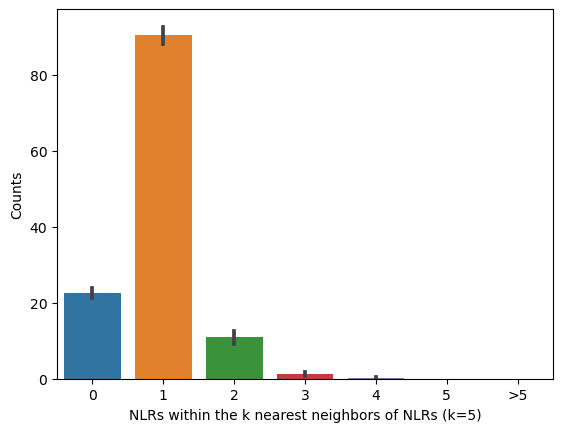

In [149]:
p1=sns.barplot(nn_nlr_plot, x="variable", y="value")
p1.set_xlabel("NLRs within the k nearest neighbors of NLRs (k=5)")
p1.set_ylabel("Counts")

In [150]:
fig = p1.get_figure()
fig.savefig("knn_5_cat_nlrs.png", bbox_inches='tight', dpi=200)

In [108]:
## get all isoforms per gene
iso_dict={}
for acc in cf["accession"].unique().tolist():
    isos=[]
    acc_df=cf.loc[cf["accession"]==acc]
    for gene in acc_df.groupby("gene"):
        if gene[0] in gene_dict[acc]:
            isos.extend(gene[1]["isoform"].tolist())
    iso_dict[acc]=isos

NameError: name 'cf' is not defined

In [216]:
for acc in iso_dict.keys():
    fasta = read(f"../../output/v2/collapse_tama/{acc}_transdecoder/{acc}_transcripts.fasta.transdecoder.pep")
    
    f_out=[]
    for g in fasta.keys():
        name = g.replace(">","").split(".")[0] +"."+ g.replace(">","").split(".")[1]
        if name in iso_dict[f"{acc}"]:
            f_out.append(g)
            
    ofile = open(f"input/n5_genes_all/{acc}_cat_nlr_like.prot.fasta", "w")

    for g in f_out:
        ofile.write(g + "\n" + fasta[g].replace("*","") + "\n")

    #do not forget to close it
    ofile.close()

### create a third run with only sqanti categories (k=10)


In [151]:
all_genes = all_genes[['genic', 'novel_not_in_catalog', 'full-splice_match',
       'incomplete-splice_match', 'novel_in_catalog', 'fusion', 'mono-exon',
       'intron_retention', 'alternative_3end5end', '3prime_fragment',
       'at_least_one_novel_splicesite', 'mono-exon_by_intron_retention',
       '5prime_fragment', 'alternative_3end', 'internal_fragment',
       'alternative_5end', 'multi-exon', 'reference_match',
       'combination_of_known_splicesites', 'combination_of_known_junctions',
       'n_ORFs', 'n_isoforms', 'n_noncoding',
       'gene', 'type', 'accession']]

In [152]:
nn_all=pd.DataFrame()
nn_nlr={}
gene_dict={}
for acc in all_genes["accession"].unique().tolist():
    # get acc subsets by type
    acc_df=all_genes.loc[all_genes["accession"]==acc]
    # hande NLR
    nlr_values=acc_df.loc[acc_df["type"]=="nlr"].drop(["accession","gene","type"], axis=1)
    nlr_values.reset_index(drop=True, inplace=True)
    nlr_labels=acc_df.loc[acc_df["type"]=="nlr"][["accession","gene","type"]]
    nlr_labels.reset_index(drop=True, inplace=True)
    
    all_values=acc_df.drop(["accession","gene","type"], axis=1)
    all_values.reset_index(drop=True, inplace=True)
    all_labels=acc_df[["accession","gene","type"]]
    all_labels.reset_index(drop=True, inplace=True)
    
    # build tree
    kdB = KDTree(all_values)
    nn= kdB.query(nlr_values, k=10)[-1]
    
    # get corresponding genes from other_labels
    ids=[]
    nn_nlr[acc]=[]
    for i in nn:
        c=0
        genes=[]
        for g in i:
            if all_labels.iloc[g]["type"] == "nlr":
                c+=1
            else:
                genes.append(all_labels.iloc[g]["gene"].split("_")[1])

        nn_nlr[acc].append(c)    
        ids.append(genes)
    
    # create full df per acc
    genes_df=pd.DataFrame(ids)
    genes_df=pd.concat([nlr_labels, genes_df], axis=1)
    nn_all=pd.concat([nn_all, genes_df])
    
    # create dict entry per acc
    gene_dict[acc]= set([g for sublist in ids for g in sublist])

In [153]:
nn_all.reset_index(inplace=True, drop=True)
nn_all["gene"]=nn_all[["gene"]].apply(lambda x: x.str.split("_").str[1])

In [154]:
nn_nlr_dict={}
for acc in nn_nlr.keys():
    nn_nlr_dict[acc]=[]
    nn_nlr_dict[acc].append(nn_nlr[acc].count(0))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(1))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(2))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(3))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(4))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(5))
    nn_nlr_dict[acc].append(sum(i > 5 for i in nn_nlr[acc]))

In [155]:
nn_nlr_dict

{'at6923': [17, 88, 12, 4, 4, 1, 0],
 'at6929': [19, 72, 23, 3, 0, 0, 0],
 'at7143': [18, 90, 16, 0, 0, 0, 0],
 'at8285': [11, 89, 11, 7, 0, 0, 0],
 'at9104': [19, 80, 21, 4, 0, 0, 0],
 'at9336': [10, 94, 13, 6, 1, 0, 0],
 'at9503': [17, 91, 15, 5, 0, 0, 0],
 'at9578': [20, 84, 17, 5, 3, 0, 0],
 'at9744': [20, 94, 23, 1, 0, 0, 0],
 'at9762': [18, 83, 23, 6, 0, 0, 0],
 'at9806': [22, 85, 17, 5, 1, 0, 0],
 'at9830': [21, 81, 13, 1, 0, 0, 0],
 'at9847': [13, 92, 19, 6, 2, 0, 0],
 'at9852': [27, 76, 16, 4, 1, 1, 0],
 'at9879': [19, 85, 12, 1, 1, 0, 0],
 'at9883': [16, 84, 18, 7, 0, 0, 0],
 'at9900': [19, 87, 18, 3, 0, 0, 0],
 'col0': [15, 85, 21, 1, 1, 0, 0]}

In [156]:
nn_nlr_df=pd.DataFrame(nn_nlr_dict)
nn_nlr_df=nn_nlr_df.T.reset_index()
nn_nlr_df.columns=["index","0","1","2","3","4","5",">5"]

In [157]:
nn_nlr_plot10=nn_nlr_df.melt(id_vars=["index"], value_vars=["0","1","2","3","4","5",">5"])

Text(0, 0.5, 'Counts')

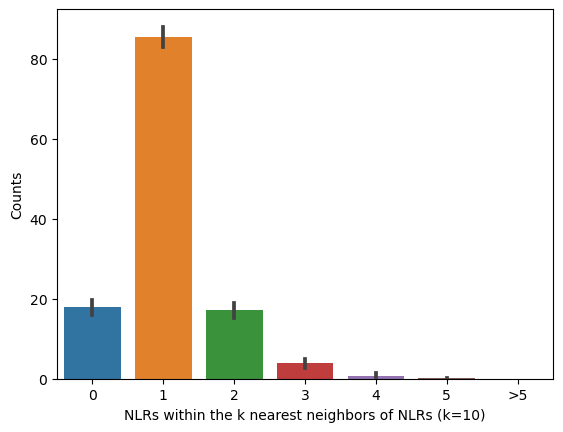

In [158]:
p1=sns.barplot(nn_nlr_plot10, x="variable", y="value")
p1.set_xlabel("NLRs within the k nearest neighbors of NLRs (k=10)")
p1.set_ylabel("Counts")

In [159]:
fig = p1.get_figure()
fig.savefig("knn_10_cat_nlrs.png", bbox_inches='tight', dpi=200)

### create a third run with only sqanti categories k=50


In [160]:
all_genes = all_genes[['genic', 'novel_not_in_catalog', 'full-splice_match',
       'incomplete-splice_match', 'novel_in_catalog', 'fusion', 'mono-exon',
       'intron_retention', 'alternative_3end5end', '3prime_fragment',
       'at_least_one_novel_splicesite', 'mono-exon_by_intron_retention',
       '5prime_fragment', 'alternative_3end', 'internal_fragment',
       'alternative_5end', 'multi-exon', 'reference_match',
       'combination_of_known_splicesites', 'combination_of_known_junctions',
       'n_ORFs', 'n_isoforms', 'n_noncoding',
       'gene', 'type', 'accession']]

In [161]:
nn_all=pd.DataFrame()
nn_nlr={}
gene_dict={}
for acc in all_genes["accession"].unique().tolist():
    # get acc subsets by type
    acc_df=all_genes.loc[all_genes["accession"]==acc]
    # hande NLR
    nlr_values=acc_df.loc[acc_df["type"]=="nlr"].drop(["accession","gene","type"], axis=1)
    nlr_values.reset_index(drop=True, inplace=True)
    nlr_labels=acc_df.loc[acc_df["type"]=="nlr"][["accession","gene","type"]]
    nlr_labels.reset_index(drop=True, inplace=True)
    
    all_values=acc_df.drop(["accession","gene","type"], axis=1)
    all_values.reset_index(drop=True, inplace=True)
    all_labels=acc_df[["accession","gene","type"]]
    all_labels.reset_index(drop=True, inplace=True)
    
    # build tree
    kdB = KDTree(all_values)
    nn= kdB.query(nlr_values, k=50)[-1]
    
    # get corresponding genes from other_labels
    ids=[]
    nn_nlr[acc]=[]
    for i in nn:
        c=0
        genes=[]
        for g in i:
            if all_labels.iloc[g]["type"] == "nlr":
                c+=1
            else:
                genes.append(all_labels.iloc[g]["gene"].split("_")[1])

        nn_nlr[acc].append(c)    
        ids.append(genes)
    
    # create full df per acc
    genes_df=pd.DataFrame(ids)
    genes_df=pd.concat([nlr_labels, genes_df], axis=1)
    nn_all=pd.concat([nn_all, genes_df])
    
    # create dict entry per acc
    gene_dict[acc]= set([g for sublist in ids for g in sublist])

In [162]:
nn_all.reset_index(inplace=True, drop=True)
nn_all["gene"]=nn_all[["gene"]].apply(lambda x: x.str.split("_").str[1])

In [163]:
nn_nlr_dict={}
for acc in nn_nlr.keys():
    nn_nlr_dict[acc]=[]
    nn_nlr_dict[acc].append(nn_nlr[acc].count(0))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(1))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(2))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(3))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(4))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(5))
    nn_nlr_dict[acc].append(sum(i > 5 for i in nn_nlr[acc]))

In [164]:
nn_nlr_df=pd.DataFrame(nn_nlr_dict)
nn_nlr_df=nn_nlr_df.T.reset_index()
nn_nlr_df.columns=["index","0","1","2","3","4","5",">5"]

In [165]:
nn_nlr_plot50=nn_nlr_df.melt(id_vars=["index"], value_vars=["0","1","2","3","4","5",">5"])

Text(0, 0.5, 'Counts')

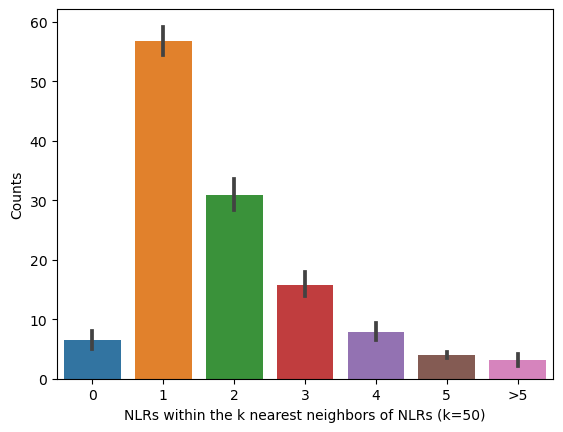

In [166]:
p1=sns.barplot(nn_nlr_plot50, x="variable", y="value")
p1.set_xlabel("NLRs within the k nearest neighbors of NLRs (k=50)")
p1.set_ylabel("Counts")

In [167]:
fig = p1.get_figure()
fig.savefig("knn_50_cat_nlrs.png", bbox_inches='tight', dpi=200)

### create a third run with only sqanti categories k=100

In [181]:
all_genes = all_genes[['genic', 'novel_not_in_catalog', 'full-splice_match',
       'incomplete-splice_match', 'novel_in_catalog', 'fusion', 'mono-exon',
       'intron_retention', 'alternative_3end5end', '3prime_fragment',
       'at_least_one_novel_splicesite', 'mono-exon_by_intron_retention',
       '5prime_fragment', 'alternative_3end', 'internal_fragment',
       'alternative_5end', 'multi-exon', 'reference_match',
       'combination_of_known_splicesites', 'combination_of_known_junctions',
       'n_ORFs', 'n_isoforms', 'n_noncoding',
       'gene', 'type', 'accession']]

In [182]:
nn_all=pd.DataFrame()
nn_nlr={}
gene_dict={}
for acc in all_genes["accession"].unique().tolist():
    # get acc subsets by type
    acc_df=all_genes.loc[all_genes["accession"]==acc]
    # hande NLR
    nlr_values=acc_df.loc[acc_df["type"]=="nlr"].drop(["accession","gene","type"], axis=1)
    nlr_values.reset_index(drop=True, inplace=True)
    nlr_labels=acc_df.loc[acc_df["type"]=="nlr"][["accession","gene","type"]]
    nlr_labels.reset_index(drop=True, inplace=True)
    
    all_values=acc_df.drop(["accession","gene","type"], axis=1)
    all_values.reset_index(drop=True, inplace=True)
    all_labels=acc_df[["accession","gene","type"]]
    all_labels.reset_index(drop=True, inplace=True)
    
    # build tree
    kdB = KDTree(all_values)
    nn= kdB.query(nlr_values, k=100)[-1]
    
    # get corresponding genes from other_labels
    ids=[]
    nn_nlr[acc]=[]
    for i in nn:
        c=0
        genes=[]
        for g in i:
            if all_labels.iloc[g]["type"] == "nlr":
                c+=1
            else:
                genes.append(all_labels.iloc[g]["gene"].split("_")[1])

        nn_nlr[acc].append(c)    
        ids.append(genes)
    
    # create full df per acc
    genes_df=pd.DataFrame(ids)
    genes_df=pd.concat([nlr_labels, genes_df], axis=1)
    nn_all=pd.concat([nn_all, genes_df])
    
    # create dict entry per acc
    gene_dict[acc]= set([g for sublist in ids for g in sublist])

In [183]:
nn_all.reset_index(inplace=True, drop=True)
nn_all["gene"]=nn_all[["gene"]].apply(lambda x: x.str.split("_").str[1])

In [184]:
nn_nlr_dict={}
for acc in nn_nlr.keys():
    nn_nlr_dict[acc]=[]
    nn_nlr_dict[acc].append(nn_nlr[acc].count(0))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(1))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(2))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(3))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(4))
    nn_nlr_dict[acc].append(nn_nlr[acc].count(5))
    nn_nlr_dict[acc].append(sum(i > 5 for i in nn_nlr[acc]))

In [185]:
nn_nlr_df=pd.DataFrame(nn_nlr_dict)
nn_nlr_df=nn_nlr_df.T.reset_index()
nn_nlr_df.columns=["index","0","1","2","3","4","5",">5"]

In [186]:
nn_nlr_plot100=nn_nlr_df.melt(id_vars=["index"], value_vars=["0","1","2","3","4","5",">5"])

Text(0, 0.5, 'Counts')

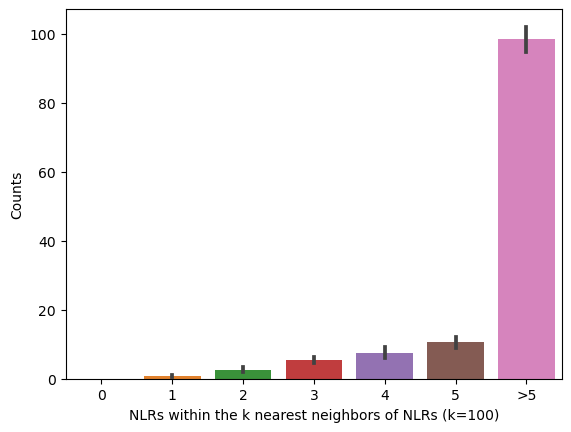

In [187]:
p1=sns.barplot(nn_nlr_plot100, x="variable", y="value")
p1.set_xlabel("NLRs within the k nearest neighbors of NLRs (k=100)")
p1.set_ylabel("Counts")

In [175]:
fig = p1.get_figure()
fig.savefig("knn_100_cat_nlrs.png", bbox_inches='tight', dpi=200)

In [188]:
nn_nlr_plot["k"]=5
nn_nlr_plot10["k"]=10
nn_nlr_plot50["k"]=50
nn_nlr_plot100["k"]=100

In [189]:
a=pd.concat([nn_nlr_plot,nn_nlr_plot10,nn_nlr_plot50,nn_nlr_plot100])

In [190]:
a

,index,variable,value,k
0,at6923,0,21,5
1,at6929,0,19,5
2,at7143,0,24,5
3,at8285,0,21,5
4,at9104,0,20,5
...,...,...,...,...
121,at9852,>5,98,100
122,at9879,>5,94,100
123,at9883,>5,98,100
124,at9900,>5,101,100


Text(0, 0.5, 'Counts')

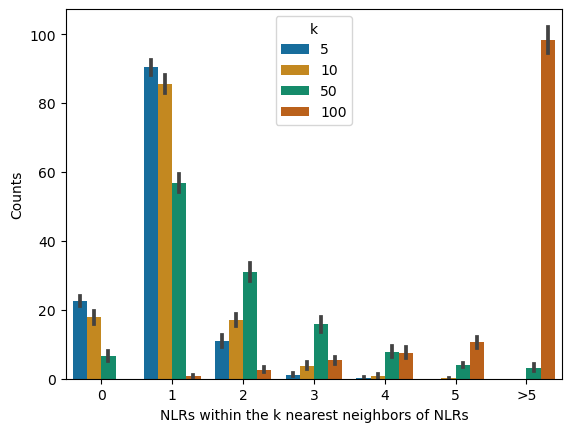

In [191]:
with sns.color_palette("colorblind"):
    p1=sns.barplot(a, x="variable", y="value", hue="k")
p1.set_xlabel("NLRs within the k nearest neighbors of NLRs")
p1.set_ylabel("Counts")

In [180]:
fig = p1.get_figure()
fig.savefig("knn_k_cat_nlrs.png", bbox_inches='tight', dpi=200)